1. Analyser le dataset (statistiques descriptives, visualisation, corrélations…) 


L’objectif est de développer un modèle de machine learning permettant de prédire la présence de calculs biliaires à partir des seules données cliniques non-imagées collectées auprès de 319 patients, en mettant en œuvre un pipeline associant :

sélection automatique de variables (SelectKBest, score f_classif)

un modèle Random Forest imposé (puis comparaison avec deux modèles annexes)

validation croisée systématique à 5-folds

2. Présentation du dataset
319 lignes (patients)

38 variables cliniques : démographie, impédancemétrie, biologie sanguine

Cible : Gallstone Status, binaire (0/1, absence/présence calculs)

Pas de valeurs manquantes, bonne balance de classes

In [1]:
import pandas as pd
df = pd.read_excel('dataset-UCI.xlsx')
print(df.shape)
df.head()
print(df['Gallstone Status'].value_counts())
print(df['Gallstone Status'].value_counts(normalize=True))


(319, 39)
Gallstone Status
0    161
1    158
Name: count, dtype: int64
Gallstone Status
0    0.504702
1    0.495298
Name: proportion, dtype: float64


In [2]:
if "Gender" in df.columns:
    print("\nRépartition du genre :")
    print(df['Gender'].value_counts())


Répartition du genre :
Gender
0    162
1    157
Name: count, dtype: int64


In [3]:
df.info


<bound method DataFrame.info of      Gallstone Status  Age  Gender  Comorbidity  \
0                   0   50       0            0   
1                   0   47       0            1   
2                   0   61       0            0   
3                   0   41       0            0   
4                   0   42       0            0   
..                ...  ...     ...          ...   
314                 1   49       0            0   
315                 1   31       1            0   
316                 1   58       0            0   
317                 1   37       1            0   
318                 1   60       1            0   

     Coronary Artery Disease (CAD)  Hypothyroidism  Hyperlipidemia  \
0                                0               0               0   
1                                0               0               0   
2                                0               0               0   
3                                0               0               0   
4    

3. Analyse du dataset

Statistiques descriptives

In [4]:
# Statistiques globales
print(df.describe())

# Statistiques des catégories
print(df['Gender'].value_counts())


       Gallstone Status         Age      Gender  Comorbidity  \
count        319.000000  319.000000  319.000000   319.000000   
mean           0.495298   48.068966    0.492163     0.335423   
std            0.500763   12.114558    0.500724     0.517340   
min            0.000000   20.000000    0.000000     0.000000   
25%            0.000000   38.500000    0.000000     0.000000   
50%            0.000000   49.000000    0.000000     0.000000   
75%            1.000000   56.000000    1.000000     1.000000   
max            1.000000   96.000000    1.000000     3.000000   

       Coronary Artery Disease (CAD)  Hypothyroidism  Hyperlipidemia  \
count                     319.000000      319.000000      319.000000   
mean                        0.037618        0.028213        0.025078   
std                         0.190568        0.165841        0.156609   
min                         0.000000        0.000000        0.000000   
25%                         0.000000        0.000000        0.0

Visualisations

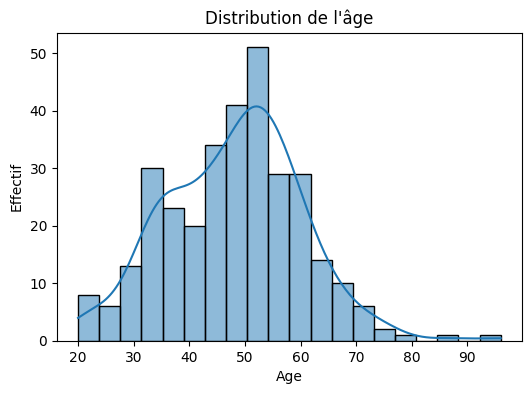

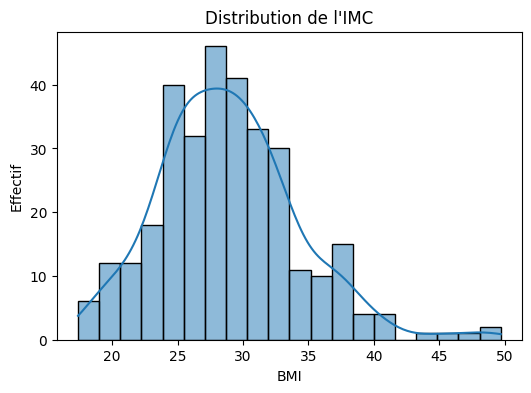

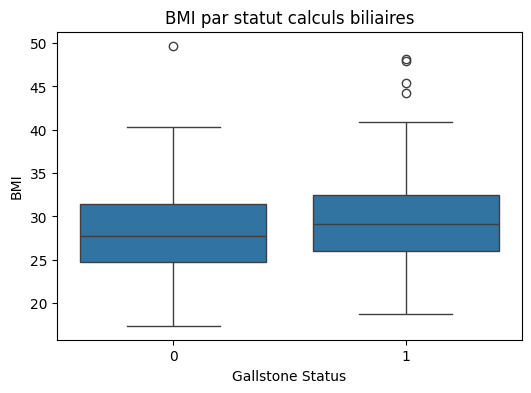

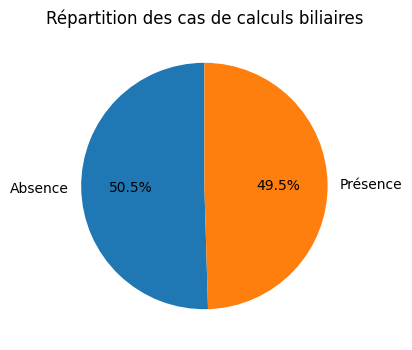

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# a) Distribution de l'âge
plt.figure(figsize=(6, 4))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Distribution de l\'âge')
plt.xlabel('Age')
plt.ylabel('Effectif')
plt.show()

# b) Distribution de l'IMC (Body Mass Index)
if "Body Mass Index (BMI)" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df['Body Mass Index (BMI)'], bins=20, kde=True)
    plt.title('Distribution de l\'IMC')
    plt.xlabel('BMI')
    plt.ylabel('Effectif')
    plt.show()

# c) Boxplot du BMI selon la présence de calculs
if "Body Mass Index (BMI)" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Gallstone Status', y='Body Mass Index (BMI)', data=df)
    plt.title('BMI par statut calculs biliaires')
    plt.xlabel('Gallstone Status')
    plt.ylabel('BMI')
    plt.show()

# d) Répartition de la variable cible
plt.figure(figsize=(4, 4))
df['Gallstone Status'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, labels=['Absence', 'Présence'])
plt.title('Répartition des cas de calculs biliaires')
plt.ylabel('')
plt.show()


Corrélations

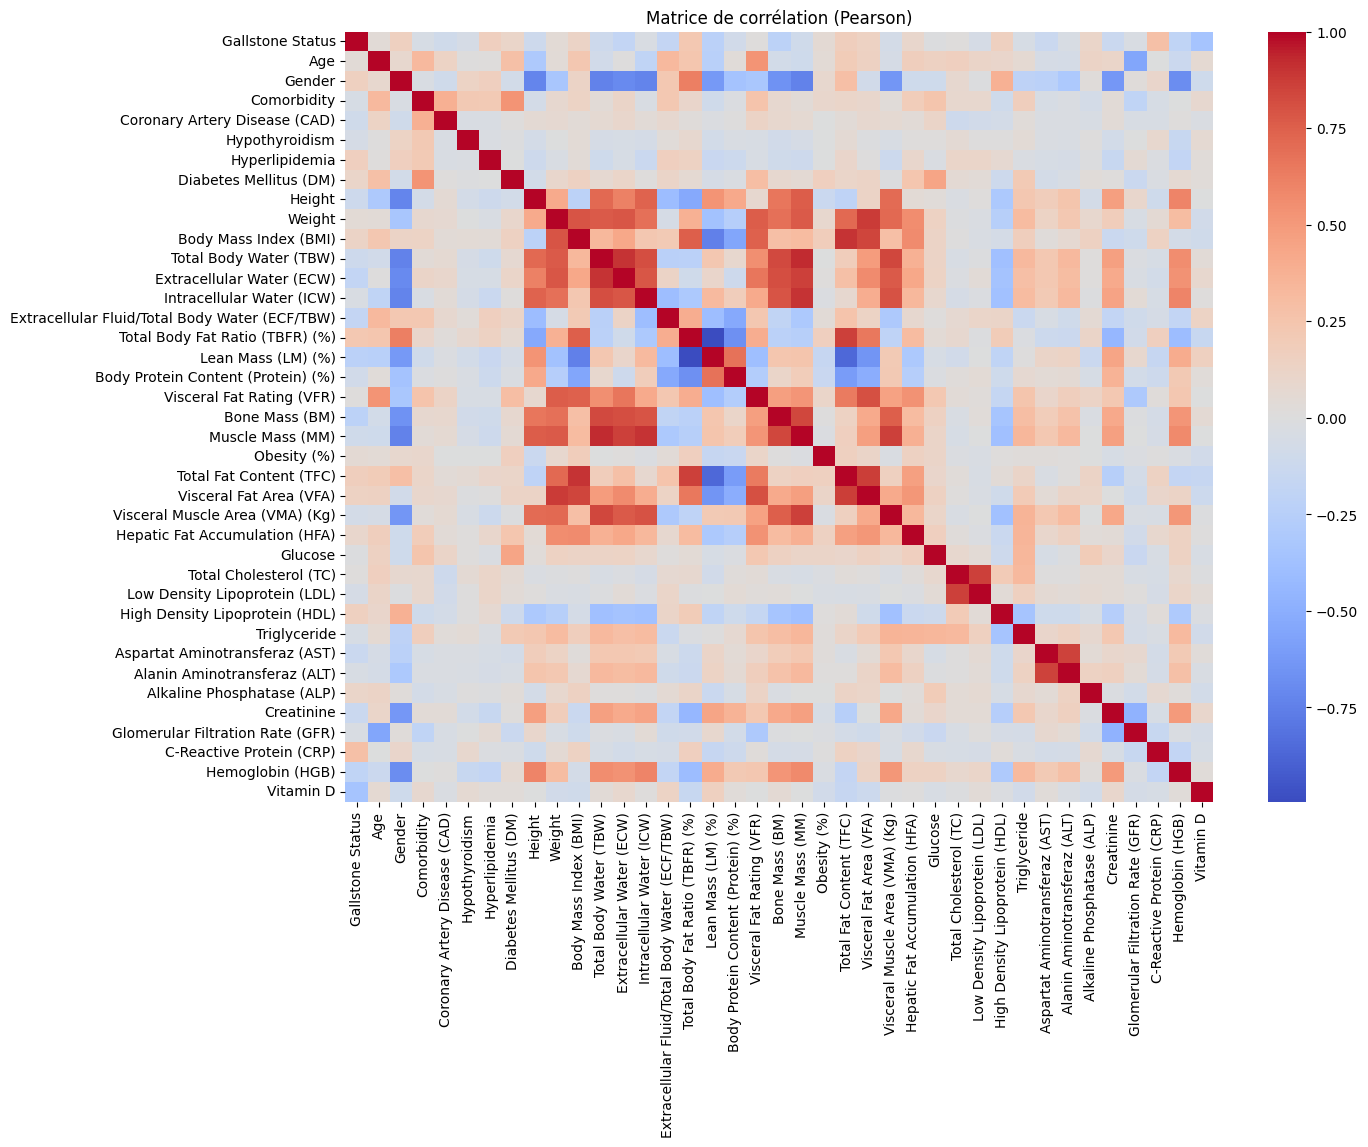

Variables les plus (positivement ou négativement) corrélées à la présence de calculs :
Gallstone Status                                  1.000000
C-Reactive Protein (CRP)                          0.281995
Total Body Fat Ratio (TBFR) (%)                   0.225470
Total Fat Content (TFC)                           0.170158
Hyperlipidemia                                    0.161901
High Density Lipoprotein (HDL)                    0.158622
Gender                                            0.153483
Visceral Fat Area (VFA)                           0.140397
Body Mass Index (BMI)                             0.121507
Alkaline Phosphatase (ALP)                        0.109882
Diabetes Mellitus (DM)                            0.104689
Hepatic Fat Accumulation (HFA)                    0.090268
Obesity (%)                                       0.053920
Weight                                            0.048669
Age                                               0.036339
Visceral Fat Rating (VFR)   

In [6]:
# a) Matrice de corrélation (seulement les colonnes numériques)
plt.figure(figsize=(14, 10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation (Pearson)')
plt.show()

# b) Corrélation de chaque variable avec la cible
cor_target = corr['Gallstone Status'].sort_values(ascending=False)
print("Variables les plus (positivement ou négativement) corrélées à la présence de calculs :")
print(cor_target)

4. Sélection des variables : méthode SelectKBest (f_classif)

Choix du nombre K à affiner (ex : 8, ici, à paramétrer).

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

X = df.drop("Gallstone Status", axis=1)
y = df["Gallstone Status"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

K = 8  # à tester pour k=5,8,12,15...
selector = SelectKBest(score_func=f_classif, k=K)
X_kbest = selector.fit_transform(X_scaled, y)
print("Variables retenues :", list(X.columns[selector.get_support()]))


Variables retenues : ['Extracellular Water (ECW)', 'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)', 'Bone Mass (BM)', 'Total Fat Content (TFC)', 'C-Reactive Protein (CRP)', 'Hemoglobin (HGB)', 'Vitamin D']


5. Modélisation : entraînement du Random Forest avec validation croisée 5-fold

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, matthews_corrcoef, mean_squared_error, confusion_matrix

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42, n_estimators=100)

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'recall': 'recall',
    'roc_auc': 'roc_auc',
    'mcc': make_scorer(matthews_corrcoef)
}
results = cross_validate(rf, X_kbest, y, cv=cv, scoring=scoring, return_estimator=True)


Affichage des scores

In [15]:
print("--- Scores en validation croisée sur 5 folds ---")
for metric in scoring.keys():
    print(f"{metric}: {results['test_'+metric].mean():.3f} (+/-{results['test_'+metric].std():.3f})")

--- Scores en validation croisée sur 5 folds ---
accuracy: 0.759 (+/-0.034)
f1: 0.744 (+/-0.044)
recall: 0.716 (+/-0.073)
roc_auc: 0.827 (+/-0.035)
mcc: 0.521 (+/-0.064)


Récupération MSE & matrice de confusion :


MSE moyen : 0.241 ± 0.034


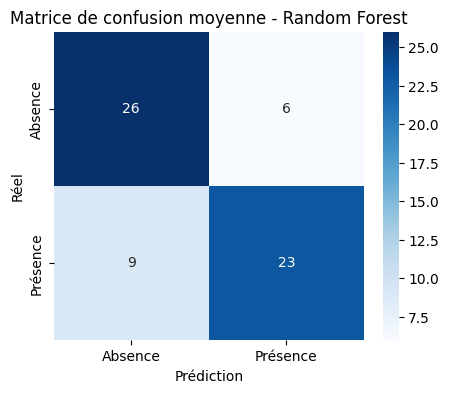

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cms = []
for train_idx, test_idx in cv.split(X_kbest, y):
    rf.fit(X_kbest[train_idx], y.iloc[train_idx])
    y_pred = rf.predict(X_kbest[test_idx])
    y_true = y.iloc[test_idx]
    cms.append(confusion_matrix(y_true, y_pred))

mean_cm = np.array(cms).mean(axis=0).round().astype(int)
print(f"\nMSE moyen : {np.mean(mses):.3f} ± {np.std(mses):.3f}")
plt.figure(figsize=(5,4))
sns.heatmap(mean_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Absence', 'Présence'],
            yticklabels=['Absence', 'Présence'])
plt.title('Matrice de confusion moyenne - Random Forest')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.show()


6. Évaluation et interprétation des résultats

In [17]:
for metric in scoring:
    values = results['test_'+metric]
    print(f"{metric:8s}: {values.mean():.3f} (+/- {values.std():.3f})")
# Résumé déjà fourni plus haut à compléter selon vos observations.


accuracy: 0.759 (+/- 0.034)
f1      : 0.744 (+/- 0.044)
recall  : 0.716 (+/- 0.073)
roc_auc : 0.827 (+/- 0.035)
mcc     : 0.521 (+/- 0.064)


7. Comparaison avec deux autres modèles (Régression Logistique, SVM RBF)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Régression Logistique": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=42)
}

for name, clf in models.items():
    print(f"\n== {name} ==")
    res = cross_validate(clf, X_kbest, y, cv=cv, scoring=scoring, return_estimator=True)
    for metric in scoring:
        values = res['test_'+metric]
        print(f"{metric:8s}: {values.mean():.3f} (+/- {values.std():.3f})")



== Random Forest ==
accuracy: 0.759 (+/- 0.034)
f1      : 0.744 (+/- 0.044)
recall  : 0.716 (+/- 0.073)
roc_auc : 0.827 (+/- 0.035)
mcc     : 0.521 (+/- 0.064)

== Régression Logistique ==
accuracy: 0.746 (+/- 0.030)
f1      : 0.726 (+/- 0.046)
recall  : 0.690 (+/- 0.095)
roc_auc : 0.809 (+/- 0.042)
mcc     : 0.500 (+/- 0.056)

== SVM (RBF) ==
accuracy: 0.743 (+/- 0.050)
f1      : 0.718 (+/- 0.068)
recall  : 0.671 (+/- 0.098)
roc_auc : 0.814 (+/- 0.036)
mcc     : 0.492 (+/- 0.097)


8. Visualisation des matrices de confusion moyennes

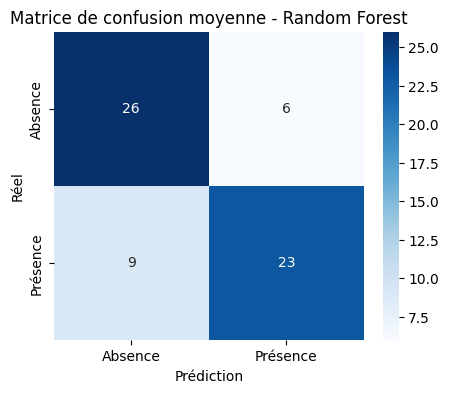

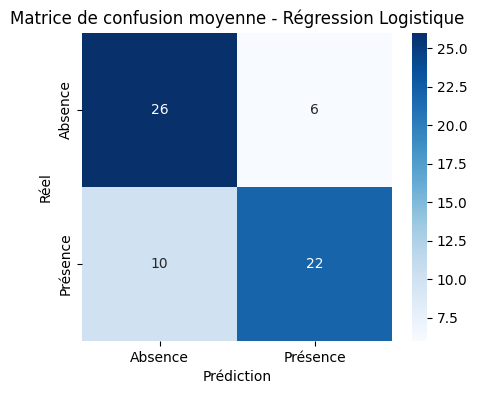

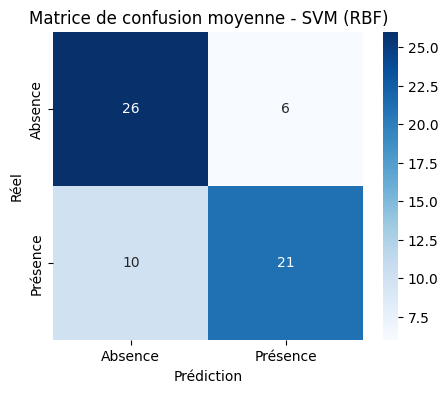

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
for name, clf in models.items():
    cms=[]
    for train_idx, test_idx in cv.split(X_kbest, y):
        clf.fit(X_kbest[train_idx], y.iloc[train_idx])
        y_pred = clf.predict(X_kbest[test_idx])
        y_true = y.iloc[test_idx]
        cms.append(confusion_matrix(y_true, y_pred))
    mean_cm = np.array(cms).mean(axis=0).round().astype(int)
    plt.figure(figsize=(5,4))
    sns.heatmap(mean_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Absence', 'Présence'], yticklabels=['Absence', 'Présence'])
    plt.title(f"Matrice de confusion moyenne - {name}")
    plt.xlabel('Prédiction')
    plt.ylabel('Réel')
    plt.show()


9. Courbes ROC, évolution score/K (pour l’annexe)

-- Scores en validation croisée (moyenne ± std) --
accuracy: 0.759 (+/- 0.034)
f1      : 0.744 (+/- 0.044)
recall  : 0.716 (+/- 0.073)
roc_auc : 0.827 (+/- 0.035)
mcc     : 0.521 (+/- 0.064)
MSE        : 0.241 (+/- 0.034)

Matrice de confusion moyenne sur 5 folds :
 [[26  6]
 [10 21]]


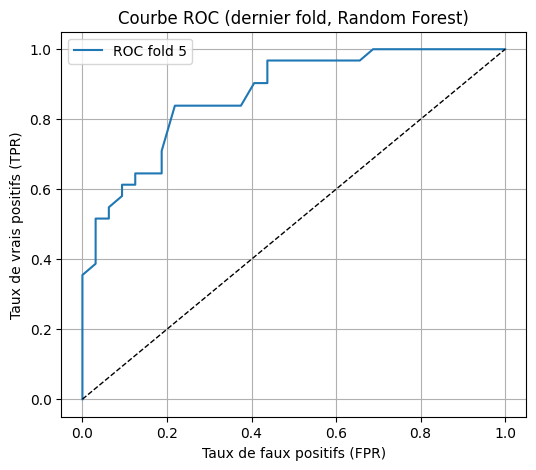

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, matthews_corrcoef, confusion_matrix, mean_squared_error, make_scorer

# 1. Données déjà préparées : X_kbest (features sélectionnées), y (cible)



cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42, n_estimators=100)


# 2. Validation croisée sur les principales métriques (hors MSE + matrice confusion)
results = cross_validate(rf, X_kbest, y, cv=cv, scoring=scoring, return_train_score=False, return_estimator=True)

# 3. MSE & matrice de confusion (non incluses par défaut dans cross_validate)
mses = []
cms = []
for i, (train_idx, test_idx) in enumerate(cv.split(X_kbest, y)):
    est = results['estimator'][i]
    y_true = y.iloc[test_idx]
    y_pred = est.predict(X_kbest[test_idx])
    mse = mean_squared_error(y_true, y_pred)
    mses.append(mse)
    cms.append(confusion_matrix(y_true, y_pred))



# 4. Synthèse des scores
print("-- Scores en validation croisée (moyenne ± std) --")
for metric in scoring:
    values = results['test_'+metric]
    print(f"{metric:8s}: {values.mean():.3f} (+/- {values.std():.3f})")
print(f"MSE        : {np.mean(mses):.3f} (+/- {np.std(mses):.3f})")

print("\nMatrice de confusion moyenne sur 5 folds :\n", mean_cm)

# 5. ROC-AUC courbe sur le dernier fold pour exemple
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

est = results['estimator'][-1]
X_test = X_kbest[test_idx]
y_true = y.iloc[test_idx]
y_prob = est.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label='ROC fold 5', color='C0')
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC (dernier fold, Random Forest)')
plt.legend()
plt.grid()
plt.show()

